In [3]:
import jax.numpy as jnp
from jax import jit, grad
import jax
import matplotlib.pyplot as plt
from IPython.display import HTML
import sys
sys.path.append("stellar-mesh-integration/")
from mesh_generation import (icosphere, vertex_to_polar, face_center,
                             apply_pulsation, mesh_polar_vertices,
                             apply_spherical_harm_pulsation, spherical_harmonic)
from celluloid import Camera

In [2]:
!pip install celluloid
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 MB 12.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.7
    Uninstalling jaxlib-0.4.7:
      Successfully uninstalled jaxlib-0.4.7


In [4]:
v, f, a, c, m, vm = icosphere(500)

rotation_matrix_x = lambda theta: jnp.array([
    [1, 0, 0],
    [0, jnp.cos(theta), -jnp.sin(theta)],
    [0, jnp.sin(theta), jnp.cos(theta)]
])

rotation_matrix_x_prim = lambda theta: jnp.array([
    [0, 0, 0],
    [0, -jnp.sin(theta), -jnp.cos(theta)],
    [0, jnp.cos(theta), -jnp.sin(theta)]
])

rotation_matrix_y = lambda theta: jnp.array([
    [jnp.cos(theta), 0, jnp.sin(theta)],
    [0, 1, 0],
    [-jnp.sin(theta), 0, jnp.cos(theta)]
])

rotation_matrix_y_prim = lambda theta: jnp.array([
    [-jnp.sin(theta), 0, jnp.cos(theta)],
    [0, 0, 0],
    [-jnp.cos(theta), 0, -jnp.sin(theta)]
])

rotation_matrix_z = lambda theta: jnp.array([
    [jnp.cos(theta), -jnp.sin(theta), 0],
    [jnp.sin(theta), jnp.cos(theta), 0],
    [0, 0, 1]
])

rotation_matrix_z_prim = lambda theta: jnp.array([
    [-jnp.sin(theta), -jnp.cos(theta), 0],
    [jnp.cos(theta), -jnp.sin(theta), 0],
    [0, 0, 0]
])

def apply_spherical_harm_pulsation(verts, faces, magnitude, m, n):
    # checkify.check(m<=n, "m has to be lesser or equal n")
    direction_vectors = verts/jnp.linalg.norm(verts, axis=1).reshape((-1, 1))
    polar_coordinates = jnp.nan_to_num(mesh_polar_vertices(verts))
    sph_ham = spherical_harmonic(m, n, polar_coordinates).real
    magnitudes = magnitude*sph_ham
    vert_offsets = magnitudes.reshape((-1, 1))*direction_vectors
    areas, centers = jax.jit(jax.vmap(face_center, in_axes=(None, 0)))(verts, faces.astype(jnp.int32))
    mus = jnp.dot(centers/jnp.linalg.norm(centers, axis=1).reshape((-1, 1)), jnp.array([0, 0, 1]))
    return vert_offsets, faces, areas, centers, mus, sph_ham.reshape((-1, 1))

def generate_frame(phase1, phase2, theta):
    ampl1 = jnp.sin(phase1)
    vel1 = jnp.cos(phase1)
    ampl2 = jnp.sin(phase2)
    vel2 = jnp.cos(phase2)
    sv_offsets1, _, _, _, _, mags1 = apply_spherical_harm_pulsation(v, f, ampl1, 0, 2.)
    sv_offsets2, _, _, _, _, mags2 = apply_spherical_harm_pulsation(v, f, ampl2, 1, 1.)
    sv = jnp.matmul(v, rotation_matrix_z(theta))
    tan_vel = jnp.matmul(sv+sv_offsets1+sv_offsets2, rotation_matrix_z_prim(theta))
    return sv+sv_offsets1+sv_offsets2, vel1*mags1+vel2*mags2, rotation_matrix_z(theta), tan_vel

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

cmap = mpl.cm.turbo

all_svs = []
all_vels = []
rot_mats = []
tan_vels = []

p1s, p2s = jnp.linspace(-np.pi, np.pi, 200), jnp.linspace(-3*np.pi, 3*np.pi, 200)

for (p1, p2), t in zip(zip(p1s, p2s), jnp.linspace(0, jnp.pi, 200)):
    sv, vel, rot_mat, tan_vel = generate_frame(p1, p2, t)
    all_svs.append(sv)
    all_vels.append(vel)
    rot_mats.append(rot_mat)
    tan_vels.append(tan_vel)

all_svs = np.array(all_svs)
all_vels = np.nan_to_num(np.array(all_vels))
tan_vels = np.nan_to_num(np.array(tan_vels))

norm = mpl.colors.Normalize(vmin=all_vels.min(), vmax=all_vels.max())


MovieWriter ffmpeg unavailable; using Pillow instead.


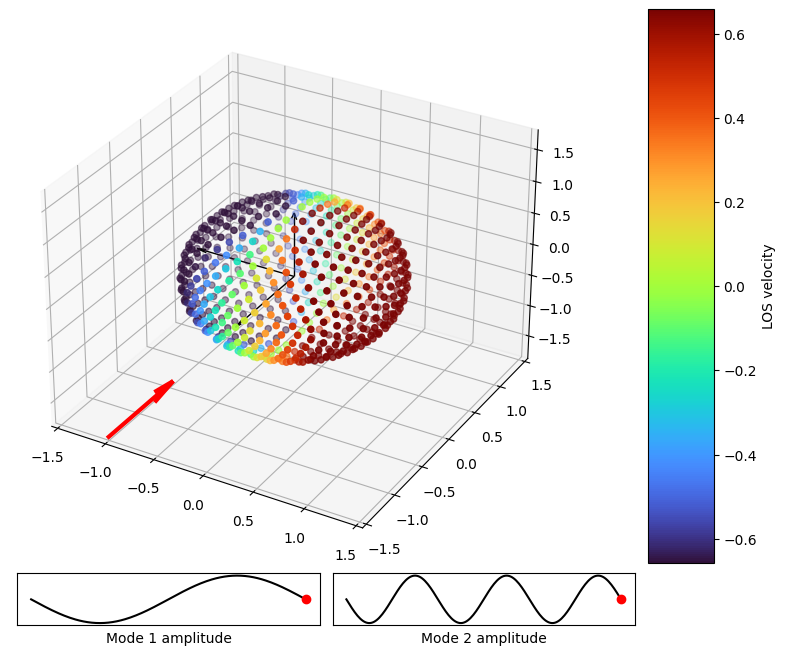

In [6]:
fig = plt.figure(figsize=(10, 8))
spec = fig.add_gridspec(10, 10)
ax1 = fig.add_subplot(spec[:9, :9], projection='3d') #spec[:9], 
ax2 = fig.add_subplot(spec[:9, 9])
ax3 = fig.add_subplot(spec[9, 1:5])
ax4 = fig.add_subplot(spec[9, 5:-1])
camera = Camera(fig)

ax1.set_xlim3d(-1.5, 1.5);
ax1.set_ylim3d(-1.5, 1.5);
ax1.set_ylim3d(-1.5, 1.5);

x, y, z = np.array([[0,0,0],[0,0,0],[0,0,0]])
qu, qv, qw = np.array([[1.,0,0], [0,1., 0],[0,0,1.]])

thetas = jnp.linspace(0, jnp.pi, 200)
los = jnp.array([0., 1., 0.])

for i, (sv, v) in enumerate(zip(all_svs, all_vels)):

    ax1.quiver(0., -3., 0., *los, color='red', linewidth=3.)

    los_vels = jnp.dot(tan_vels[i]/jnp.linalg.norm(tan_vels[i], axis=1).reshape((-1, 1)), los)

    p = ax1.scatter(sv[:, 0], sv[:, 1], sv[:, 2], c=los_vels, cmap=cmap, norm=norm);

    rqu = jnp.matmul(qu, rot_mats[i])
    rqv = jnp.matmul(qv, rot_mats[i])
    rqw = jnp.matmul(qw, rot_mats[i])

    ax1.quiver(x, y, z, rqu, rqv, rqw, arrow_length_ratio=0.1, color="black", linewidth=1.)

    # ax1.quiver(sv[::5,0], sv[::5, 1], sv[::5, 2],
    #            0.15*tan_vels[i][::5, 0], 0.15*tan_vels[i][::5, 1], 0.15*tan_vels[i][::5, 2],
    #            color='black', arrow_length_ratio=0.5, linewidth=1)

    ax3.scatter(p1s[i], np.sin(p1s[i]), color='red', zorder=2)
    ax4.scatter(p2s[i], np.sin(p2s[i]), color='red', zorder=2)

    ax3.plot(p1s, np.sin(p1s), color='black', zorder=1)
    ax3.set_xlabel('Mode 1 amplitude')
    ax4.plot(p2s, np.sin(p2s), color='black', zorder=1)
    ax4.set_xlabel('Mode 2 amplitude')

    for ax in [ax3, ax4]:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks([])
    camera.snap()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax2)
cbar.set_label('LOS velocity')

anim = camera.animate(blit=True)
anim.save('test_0_2_1_1_rot_los_vel.gif')

In [ ]:
import numpy as np

frames = []
for n, t in zip(np.sin(np.linspace(-6, 6, 100)), np.linspace(0, 4*np.pi, 100)):
    frame = plot(n, t)
    frames.append(frame)

In [ ]:
gif.save(frames, './example.gif', duration=100)